In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
import pandas as pd
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
plt.style.use('ggplot')
%matplotlib inline


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
import cifar10_input
sess = tf.InteractiveSession()
images, labels = sess.run(cifar10_input.distorted_inputs(batch_size=100))

Instructions for updating:
Colocations handled automatically by placer.


W0430 16:44:39.667495 140737270424512 deprecation.py:323] From /Users/senqicao/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/control_flow_ops.py:423: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


W0430 16:44:39.778403 140737270424512 deprecation.py:323] From /Users/senqicao/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/image_ops_impl.py:1241: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


W0430 16:17:17.331994 140737270424512 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


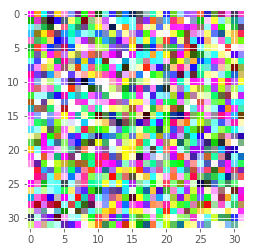

In [4]:
im = np.random.normal(0,1,[32*32*3])
im = np.reshape(np.abs(im) ,[32,32,3])
plt.imshow(im)
plt.show()
safe_images = np.reshape(np.random.normal(0,1,[32*32*3*9200]),[9200,32,32,3])

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train = np.reshape(y_train,[50000,])
y_test = np.reshape(y_test,[10000,])

M = 100
D=4*4*512
h1=1024
D2=10

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

tf.reset_default_graph()
# variables
X = tf.placeholder(tf.float32, shape = [None, 32, 32, 3])
Y = tf.placeholder(tf.float32, [None,])
b = tf.placeholder(tf.bool,shape=(),name='b')
learning_rate = tf.placeholder(tf.float32,shape=(),name='learning_rate')

w_conv1 = tf.get_variable('w_conv1', [3,3,3,128], initializer = tf.contrib.layers.xavier_initializer())
w_conv2 = tf.get_variable('w_conv2', [3,3,128,128], initializer = tf.contrib.layers.xavier_initializer())
w_conv3 = tf.get_variable('w_conv3', [3,3,128,256], initializer = tf.contrib.layers.xavier_initializer())
w_conv4 = tf.get_variable('w_conv4', [3,3,256,256], initializer = tf.contrib.layers.xavier_initializer())
w_conv5 = tf.get_variable('w_conv5', [3,3,256,512], initializer = tf.contrib.layers.xavier_initializer())
w_conv6 = tf.get_variable('w_conv6', [3,3,512,512], initializer = tf.contrib.layers.xavier_initializer())

w0 = tf.get_variable('w_fc1', [4*4*512, 1024], initializer = tf.contrib.layers.xavier_initializer())
b0 = tf.get_variable('b_fc1', [1,1024], initializer = tf.contrib.layers.xavier_initializer())
w1 = tf.get_variable('w_fc2', [1024, 10], initializer = tf.contrib.layers.xavier_initializer())
b1 = tf.get_variable('b_fc2', [1,10], initializer = tf.contrib.layers.xavier_initializer())

# network
#b=True
con1 = tf.nn.conv2d(X, w_conv1, strides=[1, 1, 1, 1], padding='SAME')
h_conv1 = tf.layers.batch_normalization(tf.nn.relu(con1), training=b)

con2 = tf.nn.conv2d(h_conv1, w_conv2, strides=[1, 1, 1, 1], padding='SAME')
h_conv2 = tf.layers.batch_normalization(tf.nn.relu(con2), training=b)
h_pool2 = max_pool_2x2(h_conv2)

con3 = tf.nn.conv2d(h_pool2, w_conv3, strides=[1, 1, 1, 1], padding='SAME')
h_conv3 = tf.layers.batch_normalization(tf.nn.relu(con3), training=b)

con4 = tf.nn.conv2d(h_conv3, w_conv4, strides=[1, 1, 1, 1], padding='SAME')
h_conv4 = tf.layers.batch_normalization(tf.nn.relu(con4), training=b)
h_pool4 = max_pool_2x2(h_conv4)

con5 = tf.nn.conv2d(h_pool4, w_conv5, strides=[1, 1, 1, 1], padding='SAME')
h_conv5 = tf.layers.batch_normalization(tf.nn.relu(con5), training=b)

con6 = tf.nn.conv2d(h_conv5, w_conv6, strides=[1, 1, 1, 1], padding='SAME')
h_conv6 = tf.layers.batch_normalization(tf.nn.relu(con6), training=b)
h_pool6 = max_pool_2x2(h_conv6)

h_pool_flat = tf.layers.flatten(h_pool6)

h = tf.nn.relu(tf.matmul(h_pool_flat, w0) + b0)
logits = tf.matmul(h, w1) + b1
output = tf.nn.softmax(logits)#batch*10

#evaluation
probs = tf.reduce_sum(output*Y,1)#batch*1
p=tf.reduce_mean(probs,0)#积分
cross_ent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits,labels = tf.cast(Y, tf.int64)))
regularization = 1e-4*(tf.reduce_sum(tf.square(w0))+tf.reduce_sum(tf.square(b0))+tf.reduce_sum(tf.square(w1))+tf.reduce_sum(tf.square(b1)))
loss = cross_ent + regularization
max_p = tf.reduce_max(output,1)
ent = tf.reduce_sum(-tf.log(output+1e-11)*output,1)

#correct_pred = tf.equal(tf.argmax(output,1), tf.argmax(Y,1))
#tmp = tf.cast(tf.argmax(output,1), tf.float32)
correct_pred = tf.equal(tf.argmax(output,1), tf.cast(Y, tf.int64))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# training
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
saver = tf.train.Saver(max_to_keep = 200)

with tf.Session() as sess:
    start_time = time.time()
    sess.run(tf.global_variables_initializer())
    model_id=0
    #save_path = saver.restore(sess, "./baseline_point_estimation/classification_mnist60/model.ckpt")
    for i in range(90000):
        
        seed = np.random.randint(0,50000,100)
        x_batch = x_train[seed]
        y_batch = y_train[seed]
        x_batch = sess.run(tf.cast(x_batch, tf.float32))
        #x_batch = sess.run(tf.random_crop(x_batch, [100, 32, 32, 3]))
        x_batch = sess.run(tf.image.random_flip_left_right(x_batch))
        x_batch = sess.run(tf.image.random_brightness(x_batch, max_delta=0.5))
        x_batch = sess.run(tf.image.random_contrast(x_batch, lower=0.2, upper=1.8))
        x_batch = sess.run(tf.image.per_image_standardization(x_batch))
        
        if i%100==0:
            maxp_OOD = []
            ent_OOD = []
            test_accuracy = []
            maxp_in = []
            ent_in = []                       
            for j in range(0,100):
                imgs_in = x_test[j*100:(j+1)*100]
                labels_in = y_test[j*100:(j+1)*100]
                #imgs_in = sess.run(tf.image.resize_image_with_crop_or_pad(imgs_in, 32, 32))
                imgs_in = sess.run(tf.image.per_image_standardization(imgs_in))
            
                acc = sess.run(accuracy,{X:np.reshape(imgs_in,[100,32,32,3]),Y:labels_in,b:False})
                maxp_in1 = sess.run(max_p,{X:np.reshape(imgs_in,[100,32,32,3]),b:False})
                ent_in1 = sess.run(ent,{X:np.reshape(imgs_in,[100,32,32,3]),b:False})
                test_accuracy.append(acc)
                maxp_in.extend(maxp_in1)
                ent_in.extend(ent_in1)
                
            test_accuracy = np.array(test_accuracy)
            maxp_in = np.array(maxp_in)
            ent_in = np.array(ent_in)
            
            safe_images = np.reshape(np.random.normal(0,1,[32*32*3*9200]),[9200,32,32,3])
            for k in range(0,92):
                imgs_OOD = safe_images[k*100:(k+1)*100]
                maxp_OOD1 = sess.run(max_p,{X:np.reshape(imgs_OOD,[100,32,32,3]),b:False})
                ent_OOD1 = sess.run(ent,{X:np.reshape(imgs_OOD,[100,32,32,3]),b:False})
                maxp_OOD.extend(maxp_OOD1)
                ent_OOD.extend(ent_OOD1)
            maxp_OOD = np.array(maxp_OOD)
            ent_OOD = np.array(ent_OOD)
            

            #validation_error = sess.run(accuracy, {X:np.reshape(validation_x,[1000,28,28,1]), Y:validation_y,b:False})
            test_error = np.mean(np.array(test_accuracy))
            print ("time:",i, time.time() - start_time, "test accuracy", test_error)
            print("maxp_OOD:",np.mean(maxp_OOD>0.99),np.mean(maxp_OOD),np.std(maxp_OOD))
            print("maxp_inD:",np.mean(maxp_in>0.99),np.mean(maxp_in),np.std(maxp_in))
            print("ent_OOD:",np.mean(ent_OOD),np.std(ent_OOD), "ent_in:", np.mean(ent_in),np.std(ent_in))
            
            safe, risky  = -np.reshape(maxp_in,[10000,1]), -np.reshape(maxp_OOD,[9200,1])
            labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
            labels[safe.shape[0]:] += 1
            examples = np.squeeze(np.vstack((safe, risky)))
            print('AUPR_p:', round(100*average_precision_score(labels, examples), 2))
            print('AUROC_p:', round(100*roc_auc_score(labels, examples), 2))

            safe, risky = np.reshape(ent_in,[10000,1]), np.reshape(ent_OOD,[9200,1])
            labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
            labels[safe.shape[0]:] += 1
            examples = np.squeeze(np.vstack((safe, risky)))
            print('AUPR_entropy:', round(100*average_precision_score(labels, examples), 2))
            print('AUROC_entropy:', round(100*roc_auc_score(labels, examples), 2))
            print("############################################")
            
        if i < 5000:
            a = 0.01
        elif i < 10000:
            a = 0.005
        elif i < 20000:
            a = 0.001
        elif i < 50000:
            a = 0.0005
        elif i < 80000:
            a = 0.0001
        else:
            a = 0.00005
        sess.run(train_step,{X: x_batch, Y: y_batch,b:True,learning_rate:a})
        
        if i%500==0:
            save_path = saver.save(sess, "./cifar10_point_estimation/classification_mnist%s/model.ckpt" % model_id)
            model_id+=1

time: 0 760.77006316185 test accuracy 0.1
maxp_OOD: 0.0 0.22459526 0.0019460786
maxp_inD: 0.0 0.22407123 0.0035607226
ent_OOD: 2.1529334 0.0021607277 ent_in: 2.156771 0.004302733
AUPR_p: 40.71
AUROC_p: 44.18
AUPR_entropy: 32.89
AUROC_entropy: 20.97
############################################
time: 100 3032.4441270828247 test accuracy 0.12990002
maxp_OOD: 0.0 0.9675659 0.004923903
maxp_inD: 0.005 0.29747906 0.18202777
ent_OOD: 0.18437599 0.022223776 ent_in: 1.9404465 0.44351938
AUPR_p: 29.3
AUROC_p: 1.11
AUPR_entropy: 29.32
AUROC_entropy: 1.2
############################################
time: 200 6848.807234048843 test accuracy 0.2669
maxp_OOD: 0.0 0.48540363 0.011853227
maxp_inD: 0.0 0.30055854 0.13327065
ent_OOD: 1.3392406 0.03261111 ent_in: 1.9040114 0.32005683
AUPR_p: 30.98
AUROC_p: 9.7
AUPR_entropy: 30.3
AUROC_entropy: 6.39
############################################
time: 300 22831.086257219315 test accuracy 0.2871
maxp_OOD: 0.0 0.68731415 0.019679548
maxp_inD: 0.0 0.32262427 0.

In [92]:
50000*100/50000

100.0

In [77]:
x_batch.shape

(100, 32, 32, 3)

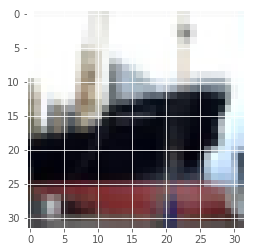

In [47]:
seed = np.random.randint(0,50000,100)
x_batch = x_train[seed]
x_batch = x_batch[0]
plt.imshow(x_batch)
plt.show()

In [80]:
sess = tf.InteractiveSession()
x_batch = sess.run(tf.cast(x_batch, tf.float32))
#x_batch = sess.run(tf.random_crop(x_batch, [32, 32, 3]))
x_batch = sess.run(tf.image.random_flip_left_right(x_batch))
x_batch = sess.run(tf.image.random_brightness(x_batch, max_delta=0.5))
x_batch = sess.run(tf.image.random_contrast(x_batch, lower=0.2, upper=1.8))
x_batch = sess.run(tf.image.per_image_standardization(x_batch))

/Users/senqicao/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


W0430 19:19:41.415526 140737270424512 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


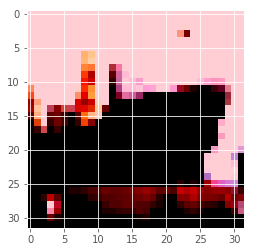

In [62]:
#x_batch = sess.run(tf.image.random_contrast(x_batch, lower=0.2, upper=1.8))
plt.imshow(x_batch)
plt.show()

In [81]:
x_batch.shape

(100, 32, 32, 3)